In [1]:
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch
import torchvision
from fastai import *
from fastai.vision import *
import numpy as np


#processing tokens

import unicodedata 
import re
import inflect 

#tokenize
from nltk import word_tokenize, sent_tokenize

#find ngrams
from nltk.util import ngrams

import time
from tqdm import tqdm

#nn
import torch.nn as nn
from torch import optim
from sklearn import preprocessing

import arpa

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())


GeForce GTX 1060 6GB
True


# load inputs from pickle file

### prefix count
### ngram count - removed
### n-1gram count 
### unigram count
### pre-pre fix count

In [17]:
#inputs = torch.load('../../pickles/50-50_5input_4793918').transpose(-2,1).float()
#outputs = torch.load('../../pickles/50-50_output_4793918').flatten().float()
inputs = torch.load('../../../pickles/50-50_5input_4793918').transpose(-2,1).float()
outputs = torch.load('../../../pickles/50-50_output_4793918').flatten().float()

inputs = 1/inputs
print(inputs)
print(outputs)
print(inputs.size())

tensor([[1.4286e-01, 5.0000e-01, 2.9789e-04, 8.0126e-06, 2.0121e-03],
        [1.6667e-01, 5.0000e-01, 1.8185e-04, 5.8883e-07, 2.0121e-03],
        [3.3333e-01, 3.3333e-01, 1.1481e-03, 2.1727e-05, 2.0121e-03],
        ...,
        [2.5000e-01, 3.3333e-01, 6.5091e-05, 3.2875e-07, 9.1324e-04],
        [2.0000e-01, 3.3333e-01, 3.1250e-02, 4.4643e-05, 5.5556e-02],
        [2.0000e-01, 5.0000e-01, 5.0000e-01, 6.7024e-04, 2.0000e-01]],
       device='cuda:0')
tensor([1.0000, 0.1667, 1.0000,  ..., 0.6000, 1.0000, 0.1429], device='cuda:0')
torch.Size([4793918, 5])


In [29]:
print(inputs[:,0:1])
print('+')
print(inputs[:,2:5])

new_inputs = torch.zeros(4793918, 4, device = device)
print('=')

new_inputs[:,0:1] = inputs[:,0:1]
new_inputs[:,1:4] = inputs[:,2:5]

print(new_inputs)

tensor([[0.1429],
        [0.1667],
        [0.3333],
        ...,
        [0.2500],
        [0.2000],
        [0.2000]], device='cuda:0')
+
tensor([[2.9789e-04, 8.0126e-06, 2.0121e-03],
        [1.8185e-04, 5.8883e-07, 2.0121e-03],
        [1.1481e-03, 2.1727e-05, 2.0121e-03],
        ...,
        [6.5091e-05, 3.2875e-07, 9.1324e-04],
        [3.1250e-02, 4.4643e-05, 5.5556e-02],
        [5.0000e-01, 6.7024e-04, 2.0000e-01]], device='cuda:0')
=
tensor([[1.4286e-01, 2.9789e-04, 8.0126e-06, 2.0121e-03],
        [1.6667e-01, 1.8185e-04, 5.8883e-07, 2.0121e-03],
        [3.3333e-01, 1.1481e-03, 2.1727e-05, 2.0121e-03],
        ...,
        [2.5000e-01, 6.5091e-05, 3.2875e-07, 9.1324e-04],
        [2.0000e-01, 3.1250e-02, 4.4643e-05, 5.5556e-02],
        [2.0000e-01, 5.0000e-01, 6.7024e-04, 2.0000e-01]], device='cuda:0')


In [6]:
if device.type == 'cuda':
    #print(torch.cuda.get_device_name(0))
    print('\nMemory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**2,1), 'MB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**2,1), 'MB')


Memory Usage:
Allocated: 110.3 MB
Cached:    298.0 MB


# Neural Net


In [30]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(4, 4)
        self.fc2 = nn.Linear(4, 4)
        self.fc3 = nn.Linear(4, 1)

        
    def forward(self, x):
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x)) 
        x = torch.sigmoid(self.fc3(x)) 
        return x

# Training

In [42]:
net = Net().cuda()
optimizer = optim.SGD(net.parameters(), lr=0.03, momentum=0.9)

criterion = torch.nn.L1Loss()  #mean absolute error
#criterion = torch.nn.MSELoss()  #mean square error

In [38]:
## run the model for 3 epochs
#for epoch in range(0,3):
for x in tqdm(range(len(new_inputs)),position=0, leave=True):
    if x % 10 == 1:
        optimizer.zero_grad() #reset gradients

        ## 1. forward propagation
        net_out = net((new_inputs[x:x+1,:]))

        ## 2. loss calculation
        loss = criterion(net_out, outputs[x].reshape(1,1))
        #print(target[x])

        ## 3. backward propagation
        loss.backward()

        ## 4. weight optimization
        optimizer.step()

100%|██████████| 4793918/4793918 [10:35<00:00, 7538.27it/s]


# Saving Model

In [44]:
torch.save(net.state_dict(), '../NN saves/temp')

# Loading model

In [6]:
net = Net().cuda()
net.load_state_dict(torch.load('NN saves/50-50_5inputs'))
net.eval()

Net(
  (fc1): Linear(in_features=5, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=1, bias=True)
)

In [39]:

net_results = np.zeros(int(len(new_inputs)/20)+1)
actual_results = np.zeros(int(len(new_inputs)/20)+1)

'''
net_results = np.zeros(len(inputs))
actual_results = np.zeros(len(inputs))
'''
count = 0

for x in tqdm(range(len(new_inputs)),position=0, leave=True):
    if x%20 == 1:
        net_results[count] = net(new_inputs[x:x+1,:])
        actual_results[count] = outputs[x]
        count += 1

net_results.sort()
actual_results.sort()

100%|██████████| 4793918/4793918 [00:59<00:00, 80347.73it/s]


# lr=0.03 m=0.9 MAE

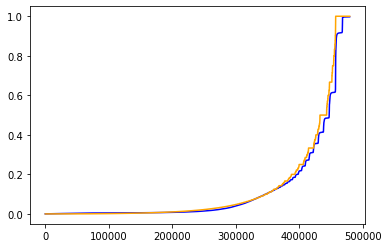

In [35]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [36]:
print(net_results)
print(actual_results)

[2.493010e-04 2.493421e-04 2.494032e-04 2.494565e-04 ... 9.971218e-01 9.971218e-01 9.971218e-01 9.971218e-01]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# lr=0.03 m=0.9 MSE

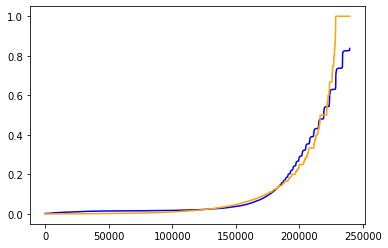

In [40]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [41]:
print(net_results)
print(actual_results)

[0.002268 0.002268 0.002268 0.002268 ... 0.835297 0.835298 0.835307 0.837021]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# lr=0.01 m=0.9 MAE

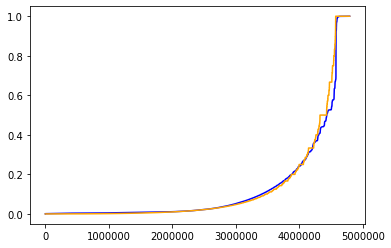

In [16]:
plt.plot(net_results,'b')
plt.plot(actual_results,'orange')
plt.show()

In [27]:
print(net_results)
print(actual_results)

[4.443272e-04 4.443272e-04 4.443340e-04 4.443340e-04 ... 9.999745e-01 9.999745e-01 9.999745e-01 9.999745e-01]
[2.60748e-06 2.60748e-06 2.60748e-06 2.60748e-06 ... 1.00000e+00 1.00000e+00 1.00000e+00 1.00000e+00]


# Visualising $P_{MLE}$ vs $P_{LM}$ vs $P_{NN}$


In [14]:
#difference = np.zeros(int(len(inputs)/10)+1)
#MLE = np.zeros(int(len(inputs)/10)+1)
#PLM = np.zeros(int(len(inputs)/10)+1)
count = 0

#difference = np.zeros(len(inputs))
MLE = np.zeros(len(inputs))
PLM = np.zeros(len(inputs))
for x in tqdm(range(len(inputs)),position=0, leave=True):
    #if x%10 == 1:
    MLE[count] = inputs[x,0]/inputs[x,1]
    PLM[count] = outputs[x]
    #difference[count] = abs(MLE[count] - PLM[count])
    count += 1

MLE.sort()
PLM.sort()
#difference.sort()
#print(MLE)
#print(PLM)

100%|██████████| 4793918/4793918 [04:40<00:00, 17090.44it/s]


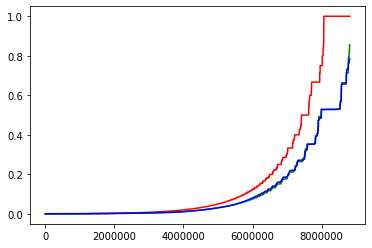

In [25]:
plt.plot(MLE , 'r')
plt.plot(PLM, 'g')
plt.plot(net_results, 'b')
#plt.plot(scaled_results, 'blue')
plt.show()

In [ ]:
# MAE

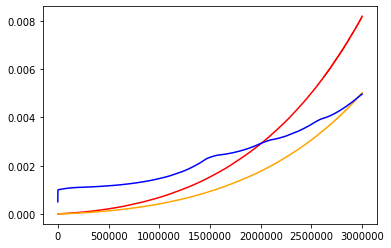

In [28]:
plt.plot(MLE[:3000000] , 'r')
plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[:3000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

In [ ]:
# MSE

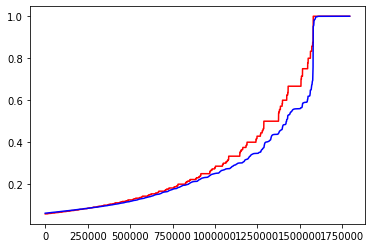

In [15]:
plt.plot(MLE[3000000:5000000] , 'r')
#plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[3000000:5000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

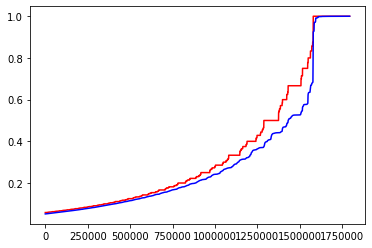

In [22]:
plt.plot(MLE[3000000:5000000] , 'r')
#plt.plot(PLM[:3000000], 'orange')
plt.plot(net_results[3000000:5000000], 'b')
#plt.plot(scaled_results[:500000], 'blue')

plt.show()

In [46]:
print(PLM[0])
print(scaled_results[0])

1.469640096729563e-06
1.469640096729563e-06
